In [1]:
import numpy as np
from scipy.stats import binom
from scipy.special import comb, gamma, kv
from functools import partial
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def gaussian_normalization(ell):
    # Integral of Gaussian covariance with lengthscale ell from 0 to infinity
    return np.sqrt(2 * np.pi * ell**2)

def matern_normalization(ell, nu):
    # Integral of Matern covariance with lengthscale ell from 0 to infinity
    return np.sqrt(2 * np.pi * ell**2) * gamma(nu + 0.5)/gamma(nu)/(nu**0.5)

def gaussian_covariance(x, ell=1.):
    x_normalized = x / ell
    return np.exp(-x_normalized**2/2)/gaussian_normalization(ell)

def matern_covariance(x, ell=1., nu=0.5):
    if np.isinf(nu): return gaussian_covariance(x,ell=ell)
    # Matern covariance with lengthscale ell    
    x[x == 0.0] += np.finfo(float).eps  # strict zeros result in nan
    x_normalized = np.sqrt(2*nu) * np.abs(x) / ell
    unnormalized_covar = (2**(1-nu) / gamma(nu)) * (x_normalized)**nu * kv(nu, x_normalized)
    return unnormalized_covar/matern_normalization(ell,nu)


In [3]:
matern_covariance(np.linspace(-5.,5.,5))

array([0.00336897, 0.0410425 , 0.5       , 0.0410425 , 0.00336897])

In [10]:
def fill(xmax,order,nu=.5):
    """ computes the rectangle rule integration of matern with given spacing"""
    n = 2*order+1
    grid = np.linspace(-xmax,xmax,n)
    fx = matern_covariance(grid,nu=nu)
    dx = xmax/order
    return fx.sum()*dx
    #return np.trapz(fx,grid)

In [162]:
def fill2(xmax,order,nu=.5):
    """"""
    n = 2*order+1
    grid = np.linspace(-xmax,xmax,n)
    f_on_grid = matern_covariance(grid,nu=nu)
    upper = (1+.5/order)*xmax
    lower = -upper
    def discretized_fn(x):
        xbin = ((x - lower)//((upper-lower)/n)).astype(int)
        return np.where((xbin>=0)|(xbin<n),f_on_grid[xbin%n],np.zeros_like(x))
    N=10000
    finegrid = np.linspace(-10,10,N)
    ISE = ((matern_covariance(finegrid,nu=nu)-discretized_fn(finegrid))**2).mean()
    return ISE

In [11]:
def binary_search(target,bounds,fn,eps=1e-2):
    lb,ub = bounds
    i = 0
    while ub-lb>eps:
        guess = (ub+lb)/2
        y = fn(guess)
        if y<target:
            lb = guess
        elif y>=target:
            ub = guess
        i+=1
        if i>500: assert False
    return (ub+lb)/2

In [20]:
order=2
fn = partial(fill,order=order,nu=np.inf)
xf = binary_search(1,(.1,10),fn,1e-3)
print(xf,fn(xf))

2.8514434814453127 0.9999999517959793


In [21]:
np.linspace(-xf,xf,2*order+1)

array([-2.85144348, -1.42572174,  0.        ,  1.42572174,  2.85144348])

In [22]:
ci = gaussian_covariance(np.linspace(-xf,xf,2*order+1))
print(ci/ci[order])

[0.01715673 0.36191669 1.         0.36191669 0.01715673]


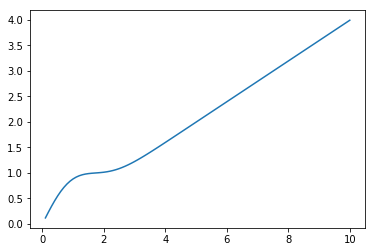

In [18]:
X = np.linspace(.1,10,100)
plt.plot(X,[fill(x,1,nu=np.inf) for x in X])

(-0.0008734489862663461, 0.10212655101373366)

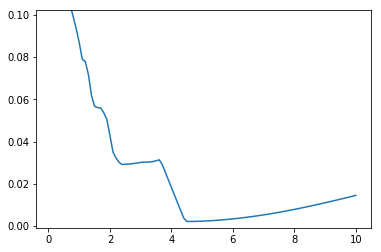

In [169]:
X = np.linspace(.1,10,100)
Y = np.array([fill2(x,2,nu=np.inf) for x in X])
plt.plot(X,Y)
plt.ylim(Y.min()-3e-3,Y.min()+1e-1)

In [145]:
X[np.argmin(Y)]

2.7

In [14]:
def binary_search(objective,bounds):
    lb,ub = bounds
    

0.06312530404709249